In [1]:
%matplotlib widget
import time
import serial
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Button
from datetime import datetime
from collections import deque

In [2]:
PORT = "/dev/cu.usbserial-0001"   
BAUD = 115200

HISTORY_SIZE = 1200              # raise later if you want
READS_PER_FRAME = 10             # how many serial reads per animation frame
INTERVAL_MS = 30                 # animation update interval in ms

serialport = None

def open_serial():
    global serialport
    if not serialport or not serialport.is_open:
        serialport = serial.Serial(PORT, BAUD, timeout=0.05)
        print("Opened", serialport.name)
        time.sleep(1.5)  # ESP32 may reset on open
        serialport.reset_input_buffer()

def close_serial():
    global serialport
    try:
        if serialport and serialport.is_open:
            serialport.close()
    except Exception:
        pass
    serialport = None

def get_mag_data():
    """Return (mx, my, mz) in µT, or None if no valid line."""
    open_serial()
    try:
        line = serialport.readline().decode("utf-8", errors="ignore").strip()
    except Exception:
        return None

    if not line.startswith("Raw:"):
        return None

    try:
        values = [v / 10.0 for v in map(float, line[4:].split(","))]
        if len(values) != 9:
            return None
        return values[6], values[7], values[8]
    except ValueError:
        return None


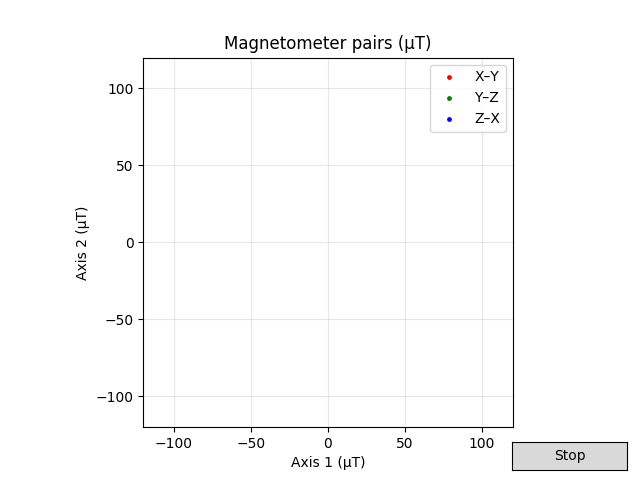

In [3]:
# ---- Live XY / YZ / ZX plot with Stop button ----
mag_x = deque(maxlen=HISTORY_SIZE)
mag_y = deque(maxlen=HISTORY_SIZE)
mag_z = deque(maxlen=HISTORY_SIZE)

recording = True

fig, ax = plt.subplots()
ax.set_aspect("equal", adjustable="box")
ax.set_title("Magnetometer pairs (µT)")
ax.set_xlabel("Axis 1 (µT)")
ax.set_ylabel("Axis 2 (µT)")
ax.grid(True, alpha=0.3)

LIM = 120
ax.set_xlim(-LIM, LIM)
ax.set_ylim(-LIM, LIM)

# Create 3 scatter artists once
sc_xy = ax.scatter([], [], s=6, c="r", label="X–Y")
sc_yz = ax.scatter([], [], s=6, c="g", label="Y–Z")
sc_zx = ax.scatter([], [], s=6, c="b", label="Z–X")
ax.legend(loc="upper right")

# Stop button
ax_stop = plt.axes([0.80, 0.02, 0.18, 0.06])
btn_stop = Button(ax_stop, "Stop")

def stop_recording(event=None):
    global recording
    recording = False
    try:
        anim.event_source.stop()
    except Exception:
        pass
    print("Recording stopped. Samples:", len(mag_x))
    
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    fname = f"mag_result_{ts}.png"

    plt.savefig(fname, dpi=200, bbox_inches="tight")
    plt.close(fig)

btn_stop.on_clicked(stop_recording)

def animate(_):
    if not recording:
        return (sc_xy, sc_yz, sc_zx)

    for _ in range(READS_PER_FRAME):
        ret = get_mag_data()
        if ret is None:
            continue
        x, y, z = ret
        mag_x.append(x); mag_y.append(y); mag_z.append(z)
    
        if len(mag_x) >= HISTORY_SIZE:
            stop_recording()
            break

    if len(mag_x) < 2:
        return (sc_xy, sc_yz, sc_zx)

    x = np.fromiter(mag_x, dtype=float)
    y = np.fromiter(mag_y, dtype=float)
    z = np.fromiter(mag_z, dtype=float)

    sc_xy.set_offsets(np.column_stack([x, y]))
    sc_yz.set_offsets(np.column_stack([y, z]))
    sc_zx.set_offsets(np.column_stack([z, x]))

    return (sc_xy, sc_yz, sc_zx)

anim = FuncAnimation(fig, animate, interval=INTERVAL_MS, blit=True, cache_frame_data=False)
plt.show()


X range:  -70.9 6.9
Y range:  -23.7 52.3
Z range:  -62.5 21.6
Final calibration in uTesla: [-32.0, 14.299999999999999, -20.45]


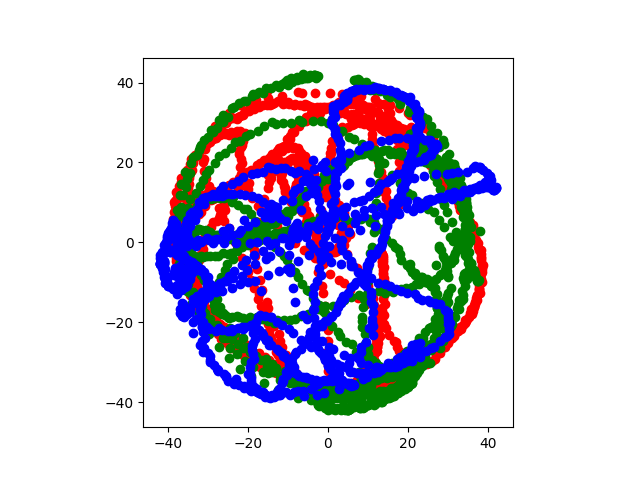

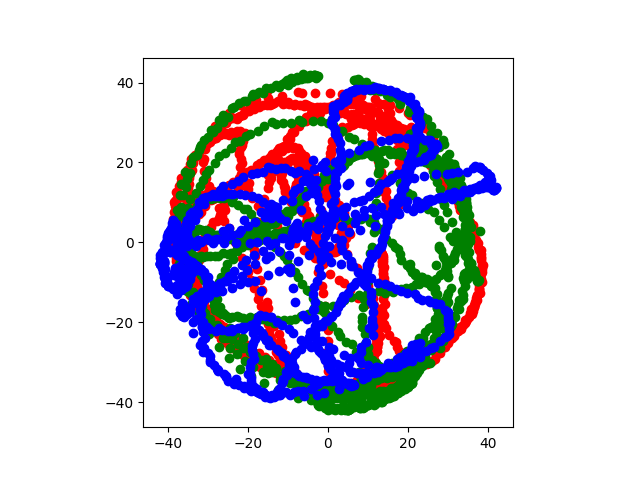

In [4]:
min_x = min(mag_x)
max_x = max(mag_x)
min_y = min(mag_y)
max_y = max(mag_y)
min_z = min(mag_z)
max_z = max(mag_z)

print("X range: ", min_x, max_x)
print("Y range: ", min_y, max_y)
print("Z range: ", min_z, max_z)

mag_calibration = [ (max_x + min_x) / 2, (max_y + min_y) / 2, (max_z + min_z) / 2]
print("Final calibration in uTesla:", mag_calibration)

cal_mag_x = [x - mag_calibration[0] for x in mag_x]
cal_mag_y = [y - mag_calibration[1] for y in mag_y]
cal_mag_z = [z - mag_calibration[2] for z in mag_z]

fig, ax = plt.subplots()
ax.set_aspect(1)
ax.cla() # clear previous defined axis

ax.scatter(cal_mag_x, cal_mag_y, color='r')
ax.scatter(cal_mag_y, cal_mag_z, color='g')
ax.scatter(cal_mag_z, cal_mag_x, color='b')
fig.show()

In [ ]:
try:
    serialport.close()
except Exception:
    pass